<a href="https://colab.research.google.com/github/sirius59/ART_AI/blob/main/ART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binôme T: De Carvalho Mickael et Laisney Clément

algorithme qui prédit le style de l'oeuvre d'art (impressionnisme, pop art, cubisme etc...) et peut être je dit bien PEUT ETRE 
arriver à un algorithme qui créer une oeuvre en fonction du style demandé.

jeu de données:
https://www.kaggle.com/ikarus777/best-artworks-of-all-time

points de départ: 

- réseau de convolution
- réduction de dimension pour classer 

retrouvez notre travail sur https://github.com/sirius59/ART_AI

### Import libraries

In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose, UpSampling2D

### Download the dataset from internet and extract it on the system

**We resized all images to 500x500 with a preview script available in the github page:** https://github.com/sirius59/ART_AI/blob/main/traitement%20des%20images.py

NB1: the csv file is a bit modified. replace space by underscore in artists names, set one genre per artists.

NB2: replace the link by a new one using this URL in case of an issue like "file is not a zipfile" https://www.mediafire.com/file/v5jpwfjeldhmc8z/dataset_resized.zip/file

In [3]:
zipurl = 'https://download1327.mediafire.com/iadjy245p01g/v5jpwfjeldhmc8z/dataset_resized.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

## Extracting metadata from artist.csv and labelize genres

In [4]:
artists=pd.read_csv('/content/dataset_resized/artists.csv')

##name of artists
name=artists.name

##genre of artists
genre=artists.genre

##number of paintings by artists
nb_paints=artists.paintings

## Binary classification

We first want to make a binary classification between 2 genre well represented in the dataset. We choose Impressionism and Baroque.

Labelize a genre with a number

In [5]:
genre_label={'Impressionism':0,'Baroque':1}

In [6]:
nb_classes=len(genre_label)

Function to find the key associated with the label

In [7]:
def find_key(v): 
    for k, val in genre_label.items(): 
        if v == val: 
            return k 
    return "Key does not exist"

### Append artworks of 2 differents styles in a list
We choose 2 differents styles well represented in the dataset en choose 4 artists of each genre in order to have about 50/50 in term of artworks

In [8]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[0]}_{1}.jpg').shape#shape of images
artworks=[]
artworks_genre=[]
genre1=(3,14,15,20,25,27,31) #selected artists in order to have ~50/50 impressionism/Baroque

for i in genre1:
  for j in range(nb_paints[i]):
    artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'))
    artworks_genre.append(genre[i])

artworks=np.array(artworks) #images
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

We choose to represent 2 differents artworks of each genre in order to visualize datas

Text(0.5, 1.0, 'Baroque')

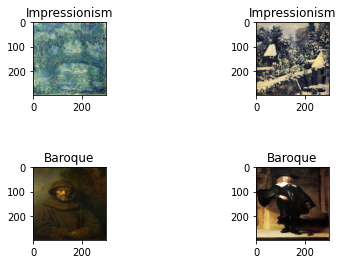

In [9]:
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[0])
plt.title(f'{artworks_genre[0]}')
plt.subplot(222)
plt.imshow(artworks[300])
plt.title(f'{artworks_genre[300]}')
plt.subplot(223)
plt.imshow(artworks[-1])
plt.title(f'{artworks_genre[-1]}')
plt.subplot(224)
plt.imshow(artworks[-200])
plt.title(f'{artworks_genre[-200]}')

### Shuffle and split of the dataset

In [10]:
prepared_label=to_categorical(artworks_label,num_classes=nb_classes) #convert label into a matrix eg: label 0 --> [1,0]; label 1 --> [0,1]

In [11]:
x_train,x_test,y_train,y_test=train_test_split(artworks,prepared_label, test_size=0.33, random_state=42, shuffle=True)
#split and shuffle the dataset into train and test datasets

### CNN

This is the Convolutional Network

In [12]:
model=Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dense(100, activation='relu')) #adding a Dense layer before the flatten layer drop the number of parameters

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(nb_classes, activation='softmax'))

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 296, 296, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 145, 145, 128)     131200    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 143, 143, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 71, 71, 128)       0         
_________________________________________________________________
dense (Dense)                (None, 71, 71, 100)       12900     
_________________________________________________________________
dropout (Dropout)            (None, 71, 71, 100)       0

In [15]:
history=model.fit(x_train,y_train, batch_size=64, epochs=12, validation_split=0.33)

Epoch 1/12
9/9 [==============================] - 37s 604ms/step - loss: 620.5858 - accuracy: 0.4918 - val_loss: 212.2975 - val_accuracy: 0.5108
Epoch 2/12
9/9 [==============================] - 3s 292ms/step - loss: 158.9159 - accuracy: 0.5348 - val_loss: 6.2792 - val_accuracy: 0.6799
Epoch 3/12
9/9 [==============================] - 3s 290ms/step - loss: 8.4249 - accuracy: 0.6849 - val_loss: 5.3088 - val_accuracy: 0.7590
Epoch 4/12
9/9 [==============================] - 3s 290ms/step - loss: 3.2367 - accuracy: 0.8120 - val_loss: 2.8349 - val_accuracy: 0.7950
Epoch 5/12
9/9 [==============================] - 3s 290ms/step - loss: 1.8495 - accuracy: 0.8075 - val_loss: 1.4488 - val_accuracy: 0.8453
Epoch 6/12
9/9 [==============================] - 3s 288ms/step - loss: 1.0471 - accuracy: 0.8638 - val_loss: 0.9265 - val_accuracy: 0.8777
Epoch 7/12
9/9 [==============================] - 3s 286ms/step - loss: 0.5992 - accuracy: 0.8798 - val_loss: 0.6999 - val_accuracy: 0.8705
Epoch 8/12
9/

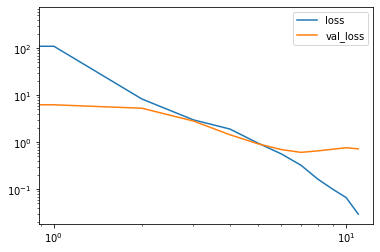

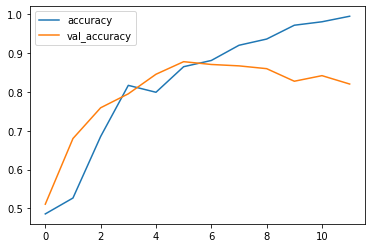

In [16]:
plt.figure()
plt.loglog(history.history['loss'],label='loss')#first values are often bigger than the rest
plt.loglog(history.history['val_loss'],label='val_loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [17]:
predict=model.predict(x_test)

In [18]:
label_prediction=np.argmax(predict, axis=1)
#select the label with the highest probability eg: [0.2,0.8] --> label_prediction=1, [0.7,0.3] --> label_prediction=0
label_solution=np.argmax(y_test, axis=1)#select the label of the solution eg: [0,1] --> label_prediction=1, [1,0] --> label_prediction=0

visualisation of random predictions with solutions

Text(0.5, 1.0, 'prediction:Impressionism\n solution:Impressionism')

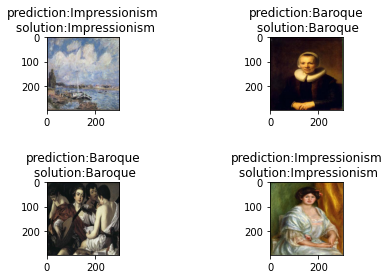

In [19]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_test[r1])
plt.title(f'prediction:{find_key(label_prediction[r1])}\n solution:{find_key(label_solution[r1])}')
plt.subplot(222)
plt.imshow(x_test[r2])
plt.title(f'prediction:{find_key(label_prediction[r2])}\n solution:{find_key(label_solution[r2])}')
plt.subplot(223)
plt.imshow(x_test[r3])
plt.title(f'prediction:{find_key(label_prediction[r3])}\n solution:{find_key(label_solution[r3])}')
plt.subplot(224)
plt.imshow(x_test[r4])
plt.title(f'prediction:{find_key(label_prediction[r4])}\n solution:{find_key(label_solution[r4])}')

In [20]:
correct=len(np.where(label_prediction==label_solution)[0]) #count the number of correct prediction
bad=len(np.where(label_prediction!=label_solution)[0]) #count the number of incorrect prediction

In [21]:
efficacity=correct/(correct+bad)
print(efficacity)

0.8599033816425121


## Add Two more genre

We add two more genre quite differents

Labelize a genre with a number

In [22]:
genre_label={'Impressionism':0,'Baroque':1,'Expressionism':2,'Pop Art':3}

In [23]:
nb_classes=len(genre_label)

Some genre are over represented so we reduce this in the section bellow

In [24]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[0]}_{1}.jpg').shape
list_genre=list(genre_label.keys())#list of genre
nb_aw_per_genre=min(nb_paints)#number of artworks per artists
artworks=[]
artworks_genre=[]

for i in list_genre:
  index_genre=np.where(genre==i)[0]
  for j in index_genre: #for each genre, for each artists it append a fraction of random artworks
    R=np.random.randint(1,nb_paints[j]+1,size=(nb_aw_per_genre//len(index_genre)))
    for k in R:
      artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[j]}_{k}.jpg'))
      artworks_genre.append(i)
artworks=np.array(artworks) #now, artworks contains 24 images per genre
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

plot random images

Text(0.5, 1.0, 'Baroque')

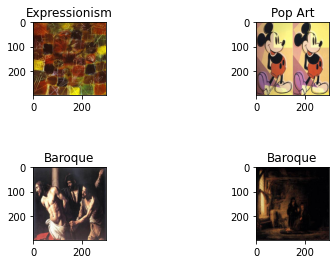

In [25]:
r1,r2,r3,r4=np.random.randint(len(artworks),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[r1])
plt.title(f'{artworks_genre[r1]}')
plt.subplot(222)
plt.imshow(artworks[r2])
plt.title(f'{artworks_genre[r2]}')
plt.subplot(223)
plt.imshow(artworks[r3])
plt.title(f'{artworks_genre[r3]}')
plt.subplot(224)
plt.imshow(artworks[r4])
plt.title(f'{artworks_genre[r4]}')

Matrix of the labels

In [26]:
prepared_label=to_categorical(artworks_label,num_classes=nb_classes)

Shuffle and split of the dataset

In [27]:
x_train,x_test,y_train,y_test=train_test_split(artworks,prepared_label, test_size=0.33, random_state=42, shuffle=True)

### Data augmentation

In [28]:
X_train=x_train.tolist()
Y_train=y_train.tolist()

In [29]:
def data_augmentation(img,genre):
  pilimg=Image.fromarray(img)
  max_size=input_shape[0]
  seed=np.random.randint(2)
  rx,ry=np.random.randint(max_size-150,size=2)#random number to fix the origine of the cropping box (-150 to avoid extrem cropping)
  rc=np.random.randint(150,min(max_size-rx,max_size-ry))#minimum cropping
  box=(rx,ry,rc,rc)
  if seed==1:
    Fimg=pilimg.transpose(np.random.randint(7))
  else:
    Fimg=pilimg
  FCimg=Fimg.crop(box)
  FCRimg=FCimg.resize((input_shape[0],input_shape[1]),3)
  FCRimg.save('tmp.jpg')
  X_train.append(plt.imread('tmp.jpg'))
  Y_train.append(genre)

In [30]:
augmentation=4
size_data=len(X_train)#avoid augmentation of already augmented images (work on the original images)

for i in range(augmentation):
  for j in range(size_data):
    data_augmentation(x_train[j],y_train[j])

In [31]:
x_train=np.array(X_train)
y_train=np.array(Y_train)

In [32]:
del(X_train,Y_train)# save RAM

In [33]:
label_train=np.argmax(y_train, axis=1)

plot random images

Text(0.5, 1.0, 'prediction:Pop Art')

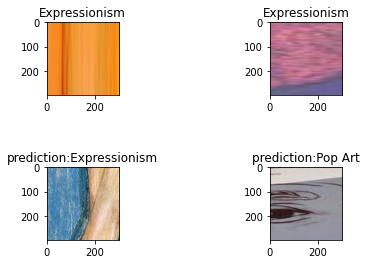

In [34]:
r1,r2,r3,r4=np.random.randint(size_data,len(x_train),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_train[r1])
plt.title(f'{find_key(label_train[r1])}')
plt.subplot(222)
plt.imshow(x_train[r2])
plt.title(f'{find_key(label_train[r2])}')
plt.subplot(223)
plt.imshow(x_train[r3])
plt.title(f'prediction:{find_key(label_train[r3])}')
plt.subplot(224)
plt.imshow(x_train[r4])
plt.title(f'prediction:{find_key(label_train[r4])}')

## CNN

In [35]:
model=Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(AveragePooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dense(100, activation='relu')) #adding a Dense layer before the flatten layer drop the number of parameters

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(nb_classes, activation='softmax'))

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 296, 296, 64)      4864      
_________________________________________________________________
average_pooling2d (AveragePo (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 145, 145, 128)     131200    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 143, 143, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 71, 71, 128)       0         
_________________________________________________________________
dense_2 (Dense)              (None, 71, 71, 100)       12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 71, 71, 100)      

In [38]:
history=model.fit(x_train,y_train, batch_size=64, epochs=25, validation_split=0.33)

Epoch 1/25
4/4 [==============================] - 4s 1s/step - loss: 733.9746 - accuracy: 0.2967 - val_loss: 200.4424 - val_accuracy: 0.2376
Epoch 2/25
4/4 [==============================] - 1s 287ms/step - loss: 333.7897 - accuracy: 0.2589 - val_loss: 330.7163 - val_accuracy: 0.3069
Epoch 3/25
4/4 [==============================] - 1s 303ms/step - loss: 350.9802 - accuracy: 0.1737 - val_loss: 137.1373 - val_accuracy: 0.2871
Epoch 4/25
4/4 [==============================] - 1s 297ms/step - loss: 121.5781 - accuracy: 0.2885 - val_loss: 27.0609 - val_accuracy: 0.4059
Epoch 5/25
4/4 [==============================] - 1s 303ms/step - loss: 38.8502 - accuracy: 0.3722 - val_loss: 28.6041 - val_accuracy: 0.2079
Epoch 6/25
4/4 [==============================] - 1s 303ms/step - loss: 21.6556 - accuracy: 0.2643 - val_loss: 8.5106 - val_accuracy: 0.3663
Epoch 7/25
4/4 [==============================] - 1s 295ms/step - loss: 9.7343 - accuracy: 0.3168 - val_loss: 6.4502 - val_accuracy: 0.4455
Epoch

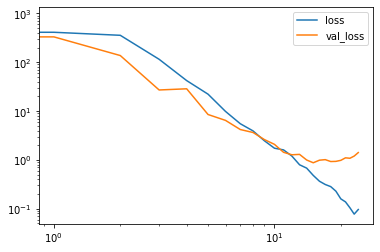

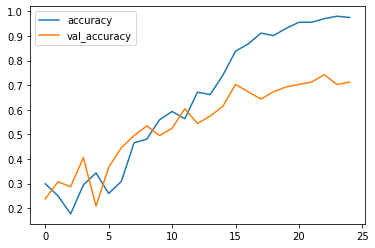

In [39]:
plt.figure()
plt.loglog(history.history['loss'],label='loss')#first values are often bigger than the rest
plt.loglog(history.history['val_loss'],label='val_loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [40]:
predict=model.predict(x_test)

In [41]:
label_prediction=np.argmax(predict, axis=1)
#select the label with the highest probability eg: [0.2,0.8] --> label_prediction=1, [0.7,0.3] --> label_prediction=0
label_solution=np.argmax(y_test, axis=1)#select the label of the solution eg: [0,1] --> label_prediction=1, [1,0] --> label_prediction=0

visualisation of random predictions with solutions

Text(0.5, 1.0, 'prediction:Expressionism\n solution:Impressionism')

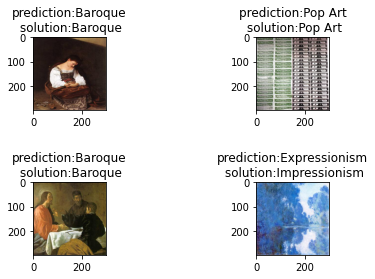

In [42]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_test[r1])
plt.title(f'prediction:{find_key(label_prediction[r1])}\n solution:{find_key(label_solution[r1])}')
plt.subplot(222)
plt.imshow(x_test[r2])
plt.title(f'prediction:{find_key(label_prediction[r2])}\n solution:{find_key(label_solution[r2])}')
plt.subplot(223)
plt.imshow(x_test[r3])
plt.title(f'prediction:{find_key(label_prediction[r3])}\n solution:{find_key(label_solution[r3])}')
plt.subplot(224)
plt.imshow(x_test[r4])
plt.title(f'prediction:{find_key(label_prediction[r4])}\n solution:{find_key(label_solution[r4])}')

In [43]:
correct=len(np.where(label_prediction==label_solution)[0]) #count the number of correct prediction
bad=len(np.where(label_prediction!=label_solution)[0]) #count the number of incorrect prediction

In [44]:
efficacity=correct/(correct+bad)
print(efficacity)

0.6129032258064516


## Add the rest of the dataset 

Labelize a genre with a number

In [45]:
k=0
genre_label={}
for i in range(len(genre)):
  if genre[i] in genre_label:#if the genre already in the dictionnary, ignore
    continue
  else:#else add it with an interger and increase it
    genre_label[genre[i]]=k
    k+=1

In [46]:
genre_label

{'Abstract Expressionism': 23,
 'Abstractionism': 1,
 'Baroque': 12,
 'Byzantine Art': 6,
 'Cubism': 11,
 'Early Renaissance': 17,
 'Expressionism': 0,
 'Fauvism': 19,
 'High Renaissance': 18,
 'Impressionism': 3,
 'Mannerism': 14,
 'Muralism': 2,
 'Neoplasticism': 21,
 'Northern Renaissance': 9,
 'Pop Art': 22,
 'Post-Impressionism': 7,
 'Primitivism': 15,
 'Proto Renaissance': 16,
 'Realism': 20,
 'Romanticism': 13,
 'Suprematism': 10,
 'Surrealism': 4,
 'Symbolism': 8,
 'impressionism': 5}

In [47]:
nb_classes=len(genre_label)

Some genre are over represented so we reduce this in the section bellow

In [48]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[0]}_{1}.jpg').shape
list_genre=list(genre_label.keys())#list of genre
nb_aw_per_genre=min(nb_paints)#number of artworks per artists
artworks=[]
artworks_genre=[]

for i in list_genre:
  index_genre=np.where(genre==i)[0]
  for j in index_genre: #for each genre, for each artists it append a fraction of random artworks
    R=np.random.randint(1,nb_paints[j]+1,size=(nb_aw_per_genre//len(index_genre)))
    for k in R:
      artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[j]}_{k}.jpg'))
      artworks_genre.append(i)
artworks=np.array(artworks) #now, artworks contains 24 images per genre
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

plot random images

Text(0.5, 1.0, 'Northern Renaissance')

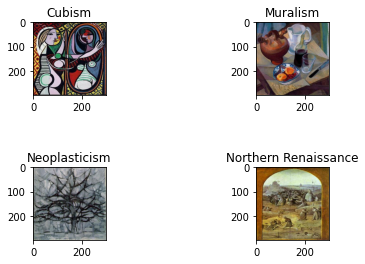

In [49]:
r1,r2,r3,r4=np.random.randint(len(artworks),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[r1])
plt.title(f'{artworks_genre[r1]}')
plt.subplot(222)
plt.imshow(artworks[r2])
plt.title(f'{artworks_genre[r2]}')
plt.subplot(223)
plt.imshow(artworks[r3])
plt.title(f'{artworks_genre[r3]}')
plt.subplot(224)
plt.imshow(artworks[r4])
plt.title(f'{artworks_genre[r4]}')

Matrix of the labels

In [50]:
prepared_label=to_categorical(artworks_label,num_classes=nb_classes)

Shuffle and split of the dataset

In [51]:
x_train,x_test,y_train,y_test=train_test_split(artworks,prepared_label, test_size=0.33, random_state=42, shuffle=True)

## Data augmentation

In [52]:
X_train=x_train.tolist()
Y_train=y_train.tolist()

In [53]:
def data_augmentation(img,genre):
  pilimg=Image.fromarray(img)
  max_size=input_shape[0]
  seed=np.random.randint(2)
  rx,ry=np.random.randint(max_size-150,size=2)#random number to fix the origine of the cropping box (-150 to avoid extrem cropping)
  rc=np.random.randint(150,min(max_size-rx,max_size-ry))#minimum cropping
  box=(rx,ry,rc,rc)
  if seed==1:
    Fimg=pilimg.transpose(np.random.randint(7))
  else:
    Fimg=pilimg
  FCimg=Fimg.crop(box)
  FCRimg=FCimg.resize((input_shape[0],input_shape[1]),3)
  FCRimg.save('tmp.jpg')
  X_train.append(plt.imread('tmp.jpg'))
  Y_train.append(genre)

In [54]:
augmentation=3
size_data=len(X_train)#avoid augmentation of already augmented images (work on the original images)

for i in range(augmentation):
  for j in range(size_data):
    data_augmentation(x_train[j],y_train[j])

In [55]:
x_train=np.array(X_train)
y_train=np.array(Y_train)

In [56]:
del(X_train,Y_train)# save RAM

In [57]:
label_train=np.argmax(y_train, axis=1)

plot random images

Text(0.5, 1.0, 'Surrealism')

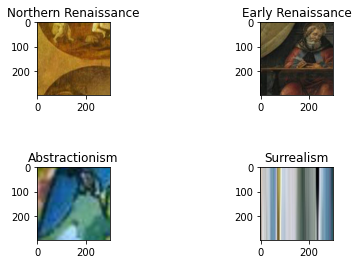

In [59]:
r1,r2,r3,r4=np.random.randint(size_data,len(x_train),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_train[r1])
plt.title(f'{find_key(label_train[r1])}')
plt.subplot(222)
plt.imshow(x_train[r2])
plt.title(f'{find_key(label_train[r2])}')
plt.subplot(223)
plt.imshow(x_train[r3])
plt.title(f'{find_key(label_train[r3])}')
plt.subplot(224)
plt.imshow(x_train[r4])
plt.title(f'{find_key(label_train[r4])}')

## CNN

We need to make a better model (add some Averagepooling2D)

In [60]:
model=Sequential()

model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=2))

model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=2))

model.add(Dense(100, activation='relu')) #adding a Dense layer before the flatten layer drop the number of parameters

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(nb_classes, activation='softmax'))

In [61]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 147, 147, 64)      36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 33, 33, 64)       

In [63]:
history=model.fit(x_train,y_train, batch_size=64, epochs=10, validation_split=0.33)

Epoch 1/10
16/16 [==============================] - 7s 332ms/step - loss: 8.5830 - accuracy: 0.0348 - val_loss: 3.2107 - val_accuracy: 0.0558
Epoch 2/10
16/16 [==============================] - 3s 201ms/step - loss: 3.1636 - accuracy: 0.0564 - val_loss: 3.2405 - val_accuracy: 0.0558
Epoch 3/10
16/16 [==============================] - 3s 199ms/step - loss: 3.0792 - accuracy: 0.0997 - val_loss: 3.1522 - val_accuracy: 0.0618
Epoch 4/10
16/16 [==============================] - 3s 200ms/step - loss: 2.9046 - accuracy: 0.1772 - val_loss: 3.3910 - val_accuracy: 0.0618
Epoch 5/10
16/16 [==============================] - 3s 200ms/step - loss: 2.3818 - accuracy: 0.3006 - val_loss: 3.6134 - val_accuracy: 0.0637
Epoch 6/10
16/16 [==============================] - 3s 203ms/step - loss: 1.8681 - accuracy: 0.4897 - val_loss: 4.6989 - val_accuracy: 0.0737
Epoch 7/10
16/16 [==============================] - 3s 201ms/step - loss: 1.4310 - accuracy: 0.5800 - val_loss: 4.7526 - val_accuracy: 0.0697
Epoch 

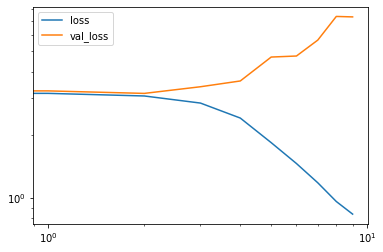

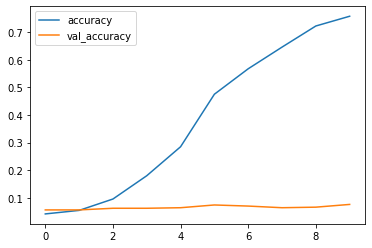

In [64]:
plt.figure()
plt.loglog(history.history['loss'],label='loss')#first values are often bigger than the rest
plt.loglog(history.history['val_loss'],label='val_loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [65]:
predict=model.predict(x_test)

In [66]:
label_prediction=np.argmax(predict, axis=1)
label_solution=np.argmax(y_test, axis=1)

Text(0.5, 1.0, 'prediction:Neoplasticism\n solution:Pop Art')

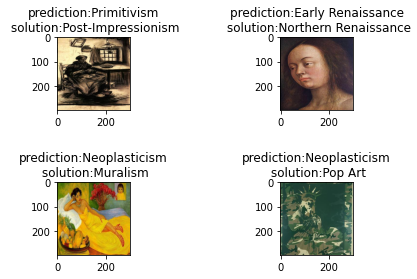

In [67]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_test[r1])
plt.title(f'prediction:{find_key(label_prediction[r1])}\n solution:{find_key(label_solution[r1])}')
plt.subplot(222)
plt.imshow(x_test[r2])
plt.title(f'prediction:{find_key(label_prediction[r2])}\n solution:{find_key(label_solution[r2])}')
plt.subplot(223)
plt.imshow(x_test[r3])
plt.title(f'prediction:{find_key(label_prediction[r3])}\n solution:{find_key(label_solution[r3])}')
plt.subplot(224)
plt.imshow(x_test[r4])
plt.title(f'prediction:{find_key(label_prediction[r4])}\n solution:{find_key(label_solution[r4])}')

In [68]:
correct=len(np.where(label_prediction==label_solution)[0])
bad=len(np.where(label_prediction!=label_solution)[0])

In [69]:
efficacity=correct/(bad+correct)
print(efficacity)

0.15425531914893617
